In [47]:
import pandas as pd
import numpy as np

from pprint import pprint

from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, roc_auc_score, f1_score, roc_curve, auc, precision_recall_curve, average_precision_score
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV, train_test_split, cross_val_score

from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier

import import_ipynb
import algocryptos_preprocessing as alg_preproc
from utils_csa import show_model_accuracy, save_obj, load_obj, evaluate_model, evaluate_model_formated

# from sklearn.metrics import SCORERS
# print(SCORERS.keys())

In [48]:
dict_hours_labels  = {24:'1d'}
predict_only_one_crypto = True
y_to_be_considered = 'y_+1d_classif'
close_price_increase_targeted = +5
threshold = 0.85
id_cryptocompare_1 = "7605"

dict_df = load_obj('dict_df_2018_12_03_top10')

X_train_1, X_test_1, y_train_1, y_test_1, X_train_close_price_1, X_test_close_price_1 = alg_preproc.get_preprocessed_data(dict_df, dict_hours_labels, 
                                                                     close_price_increase_targeted, 
                                                                     False,
                                                                     do_scale=False, 
                                                                     do_pca=True,
                                                                     id_cryptocompare=id_cryptocompare_1)

In [49]:
#Import libraries:
import xgboost as xgb
from xgboost.sklearn import XGBClassifier

import matplotlib.pylab as plt
%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 12, 4

# TODO : Add test ?
def modelfit(alg, X_, y_, X_test=None, y_test=None, useTrainCV=False, cv_folds=5, early_stopping_rounds=50, metrics='auc'):    
    # Allow to find the best n_estimators parameter
    if useTrainCV:
        xgb_param = alg.get_xgb_params()
        xgtrain = xgb.DMatrix(X_, label=y_)
        cvresult = xgb.cv(xgb_param, xgtrain, num_boost_round=alg.get_params()['n_estimators'], nfold=cv_folds,
            metrics=metrics, early_stopping_rounds=early_stopping_rounds, verbose_eval=False) #verbose_eval=True
        alg.set_params(n_estimators=cvresult.shape[0])
    
    #Fit the algorithm on the data
    alg.fit(X_, y_, eval_metric=metrics)
    modelscore(alg, X_, y_, X_test, y_test)

def modelscore(alg, X_, y_, X_test=None, y_test=None):      
    #Predict training set:
    dtrain_predictions = alg.predict(X_)
    dtrain_predprob = alg.predict_proba(X_)[:,1]
        
    #Print model report:
    print("\nModel Report:")
    print("Accuracy (Train): " + str(accuracy_score(y_, dtrain_predictions)))
    print("AUC Score (Train): " + str(roc_auc_score(y_, dtrain_predprob)))
    print("F1 Score (Train): " + str(f1_score(y_, dtrain_predictions)))
    
    if (X_test is not None) and (y_test is not None):
        # Predict testing set:
        dtest_predictions = alg.predict(X_test)
        dtest_predprob = alg.predict_proba(X_test)[:,1]
        
        print("Accuracy (Test): " + str(accuracy_score(y_test, dtest_predictions)))
        print("AUC Score (Test): " + str(roc_auc_score(y_test, dtest_predprob)))
        print("F1 Score (Test): " + str(f1_score(y_test, dtest_predictions)))
                    
    feat_imp = pd.Series(alg.get_booster().get_fscore()).sort_values(ascending=False)
    feat_imp.plot(kind='bar', title='Feature Importances')
    plt.ylabel('Feature Importance Score')
    plt.show()


Model Report:
Accuracy (Train): 0.8220159562107873
AUC Score (Train): 0.9067261655790534
F1 Score (Train): 0.6484074159079898
Accuracy (Test): 0.45384645106448745
AUC Score (Test): 0.7145418210183585
F1 Score (Test): 0.21415466725968757


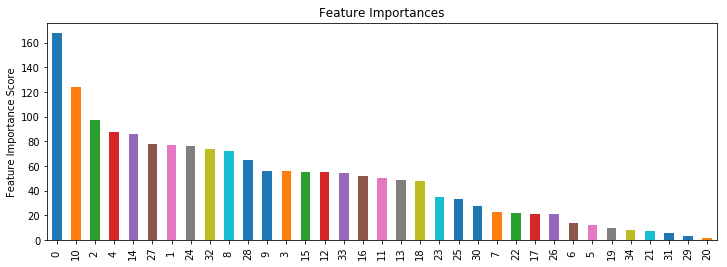

In [21]:
# Step 1: Find the ideal n-estimator param (fail 1000 => use fixed 60)
n_estimators=60
scale_pos_weight = y_train_1[y_to_be_considered].value_counts()[False] / y_train_1[y_to_be_considered].value_counts()[True]
#scale_pos_weight = 1
xgb1 = XGBClassifier(
            learning_rate =0.1,
            n_estimators=n_estimators,
            max_depth=5,
            min_child_weight=1,
            gamma=0,
            subsample=0.8,
            colsample_bytree=0.8,
            objective= 'binary:logistic',
            nthread=-1,
            scale_pos_weight=scale_pos_weight,
            seed=27)
modelfit(xgb1, X_train_1, y_train_1[y_to_be_considered], X_test=X_test_1, y_test=y_test_1[y_to_be_considered], metrics='auc')

In [10]:
# Step 2: Tune max_depth and min_child_weight
param_test2 = {
 'max_depth':range(3,15,1),
 'min_child_weight':range(1,6,1)
}

xgb2 = XGBClassifier(
            learning_rate =0.1,
            n_estimators=n_estimators,
            max_depth=5,
            min_child_weight=1,
            gamma=0,
            subsample=0.8,
            colsample_bytree=0.8,
            objective= 'binary:logistic',
            nthread=-1,
            scale_pos_weight=scale_pos_weight,
            seed=27)

gsearch2 = GridSearchCV(estimator = xgb2, param_grid = param_test2, scoring='f1',n_jobs=-1,iid=False, cv=5) #scoring='roc_auc'
gsearch2.fit(X_train_1, y_train_1[y_to_be_considered])
print(gsearch2.cv_results_)
print(gsearch2.best_params_)
print(gsearch2.best_score_)

# modelfit(gsearch2.best_estimator_, X_train_1, y_train_1[y_to_be_considered], X_test=X_test_1, y_test=y_test_1[y_to_be_considered], metrics='auc')

{'mean_fit_time': array([13.52652097, 13.91437058, 13.8587409 , 13.92702174, 13.65657392,
       18.04827933, 17.74735994, 17.92290578, 17.92620821, 17.9051403 ,
       22.47791591, 22.1846549 , 22.39891734, 22.04495406, 22.20818629,
       27.08852568, 26.80660343, 27.27203455, 26.61075988, 26.62145429,
       32.55386658, 31.61091866, 31.8890945 , 31.35111079, 31.56155071,
       37.48429418, 37.83224907, 37.00393987, 36.80578423, 36.20868754,
       41.9751627 , 42.84751711, 41.72015433, 41.86515284, 41.2185266 ,
       48.19129872, 47.35169263, 46.95785351, 46.76287885, 46.09031367,
       52.63926191, 52.23467135, 51.85361452, 51.24172211, 50.80390568,
       57.66019654, 58.08086138, 57.00283704, 56.4455111 , 56.02459264,
       62.56646948, 61.89138923, 60.91281476, 59.30384173, 56.29402881,
       58.96422338, 50.6219523 , 49.34723868, 46.91711788, 42.61273031]), 'std_fit_time': array([0.09579555, 0.19493913, 0.30743955, 0.38911972, 0.11039357,
       0.38596668, 0.11522501, 0.

In [15]:
max_depth=gsearch2.best_params_['max_depth']
min_child_weight=gsearch2.best_params_['min_child_weight']
param_test3 = {
 'gamma':[i/10.0 for i in range(0,15)]
}

xgb3 = XGBClassifier(
            learning_rate =0.1,
            n_estimators=n_estimators,
            max_depth=max_depth,
            min_child_weight=min_child_weight,
            gamma=0,
            subsample=0.8,
            colsample_bytree=0.8,
            objective= 'binary:logistic',
            nthread=-1,
            scale_pos_weight=scale_pos_weight,
            seed=27)

gsearch3 = GridSearchCV(estimator = xgb3, param_grid = param_test3, scoring='f1',n_jobs=-1,iid=False, cv=5) #scoring='roc_auc'
gsearch3.fit(X_train_1, y_train_1[y_to_be_considered])
print(gsearch3.cv_results_)
print(gsearch3.best_params_)
print(gsearch3.best_score_)

{'mean_fit_time': array([13.58100476, 13.48801708, 13.54762735, 13.56476393, 13.61409698,
       13.45002317, 13.44729371, 13.6109395 , 13.73582373, 13.49709902,
       13.56004987,  9.1026566 ,  7.62170982,  7.64351387,  7.58910413]), 'std_fit_time': array([0.29546106, 0.11078711, 0.12178368, 0.12427031, 0.3462232 ,
       0.14527538, 0.07553873, 0.14571545, 0.35217159, 0.15865677,
       0.07706152, 2.07924245, 0.14989356, 0.11404011, 0.15143907]), 'mean_score_time': array([0.05465512, 0.05048981, 0.06182675, 0.04677782, 0.05494342,
       0.06703181, 0.06266174, 0.05362854, 0.04750099, 0.04638748,
       0.04232674, 0.03793564, 0.03751049, 0.03048868, 0.03606329]), 'std_score_time': array([0.0056571 , 0.00464644, 0.02488182, 0.00487312, 0.01415464,
       0.01906043, 0.01005198, 0.00655868, 0.01290717, 0.00667295,
       0.00823889, 0.00670406, 0.00586098, 0.00298395, 0.00794009]), 'param_gamma': masked_array(data=[0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0,
             

In [18]:
# Step 4: Tune subsample and colsample_bytree
gamma=gsearch3.best_params_['gamma']
param_test4 = {
 'subsample':[i/10.0 for i in range(6,10)],
 'colsample_bytree':[i/10.0 for i in range(6,10)]
}

scale_pos_weight = 1
xgb4 = XGBClassifier(
            learning_rate =0.1,
            n_estimators=n_estimators,
            max_depth=max_depth,
            min_child_weight=min_child_weight,
            gamma=gamma,
            subsample=0.8,
            colsample_bytree=0.8,
            objective= 'binary:logistic',
            nthread=-1,
            scale_pos_weight=scale_pos_weight,
            seed=27)

gsearch4 = GridSearchCV(estimator = xgb4, param_grid = param_test4, scoring='f1',n_jobs=-1,iid=False, cv=5) #scoring='roc_auc'
gsearch4.fit(X_train_1, y_train_1[y_to_be_considered])
print(gsearch4.cv_results_)
print(gsearch4.best_params_)
print(gsearch4.best_score_)

{'mean_fit_time': array([ 9.65636382, 10.18500133, 10.75400648, 11.38166065, 10.74073167,
       11.15583577, 12.00575132, 12.64052835, 11.87728586, 12.59790659,
       13.1868607 ,  9.89661832,  8.68103375,  8.6028017 ,  8.56286855,
        9.36945324]), 'std_fit_time': array([0.09710646, 0.2613989 , 0.25841087, 0.19566439, 0.17486191,
       0.08619387, 0.24281783, 0.26182924, 0.21907727, 0.08028639,
       0.3306627 , 1.57557348, 0.47400618, 0.55458196, 0.20388462,
       0.53509095]), 'mean_score_time': array([0.05603914, 0.06097174, 0.05762811, 0.05950785, 0.04960022,
       0.05187254, 0.05294943, 0.04854383, 0.0502182 , 0.04641757,
       0.03827014, 0.03243904, 0.03902464, 0.03372006, 0.03441124,
       0.03152809]), 'std_score_time': array([0.00876656, 0.00996459, 0.01102717, 0.01028041, 0.00188866,
       0.00521725, 0.0171787 , 0.00732224, 0.00397824, 0.00736045,
       0.00366475, 0.00181927, 0.00744976, 0.00447459, 0.00684337,
       0.004827  ]), 'param_colsample_bytree':

In [19]:
# Step 5: Tuning Regularization Parameters
colsample_bytree= gsearch4.best_params_['colsample_bytree']
subsample= gsearch4.best_params_['subsample']
param_test5 = {
 'reg_alpha':[1e-5, 1e-2, 0.1, 1, 100]
}

xgb5 = XGBClassifier(
            learning_rate =0.1,
            n_estimators=n_estimators,
            max_depth=max_depth,
            min_child_weight=min_child_weight,
            gamma=gamma,
            subsample=subsample,
            colsample_bytree=colsample_bytree,
            objective= 'binary:logistic',
            nthread=-1,
            scale_pos_weight=scale_pos_weight,
            seed=27)

gsearch5 = GridSearchCV(estimator = xgb5, param_grid = param_test5, scoring='f1',n_jobs=-1,iid=False, cv=5) #scoring='roc_auc'
gsearch5.fit(X_train_1, y_train_1[y_to_be_considered])
print(gsearch5.cv_results_)
print(gsearch5.best_params_)
print(gsearch5.best_score_)

{'mean_fit_time': array([8.28010273, 8.20316353, 8.20112839, 8.21332455, 8.48181744]), 'std_fit_time': array([0.05228991, 0.07472801, 0.10852743, 0.10907455, 0.18159122]), 'mean_score_time': array([0.0417963 , 0.03257279, 0.03243198, 0.03668113, 0.03175745]), 'std_score_time': array([0.00919591, 0.00196854, 0.00297921, 0.00906579, 0.00426986]), 'param_reg_alpha': masked_array(data=[1e-05, 0.01, 0.1, 1, 100],
             mask=[False, False, False, False, False],
       fill_value='?',
            dtype=object), 'params': [{'reg_alpha': 1e-05}, {'reg_alpha': 0.01}, {'reg_alpha': 0.1}, {'reg_alpha': 1}, {'reg_alpha': 100}], 'split0_test_score': array([0.3396609 , 0.33968004, 0.33555992, 0.3337598 , 0.32868664]), 'split1_test_score': array([0.00219391, 0.00219391, 0.00219391, 0.0016852 , 0.00207275]), 'split2_test_score': array([0., 0., 0., 0., 0.]), 'split3_test_score': array([0.00862069, 0.00989302, 0.00989416, 0.00972053, 0.01240835]), 'split4_test_score': array([0., 0., 0., 0., 0.]), 


Model Report:
Accuracy (Train): 0.7388009604709406
AUC Score (Train): 0.7988281245812578
F1 Score (Train): 0.5136648799365431
Accuracy (Test): 0.5204203856110661
AUC Score (Test): 0.6746398303532856
F1 Score (Test): 0.2231818750782326


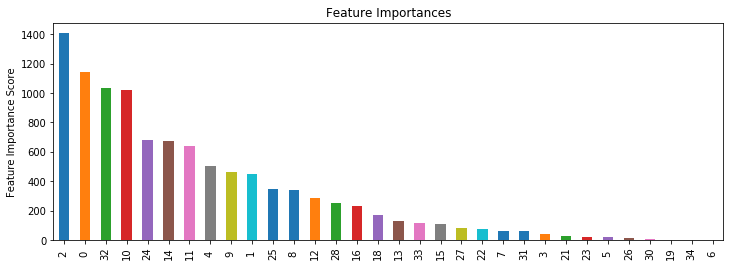

In [57]:
# TEST
reg_alpha = gsearch5.best_params_['reg_alpha']
learning_rate = learning_rate / 10
n_estimators = n_estimators * 5
xgbx = XGBClassifier(
            learning_rate =learning_rate,
            n_estimators=n_estimators,
            max_depth=max_depth,
            min_child_weight=min_child_weight,
            gamma=gamma,
            subsample=subsample,
            colsample_bytree=colsample_bytree,
            objective= 'binary:logistic',
            nthread=-1,
            scale_pos_weight=scale_pos_weight,
            reg_alpha=reg_alpha,
            seed=27)

modelfit(xgbx, X_train_1, y_train_1[y_to_be_considered], X_test=X_test_1, y_test=y_test_1[y_to_be_considered], useTrainCV=False, metrics='auc')

In [ ]:
# Init result
# Model Report:
# Accuracy (Train): 0.9146291084660866
# AUC Score (Train): 0.9676550841138831
# F1 Score (Train): 0.7414676101489504
# Accuracy (Test): 0.7429774738224952
# AUC Score (Test): 0.7066769633276778
# F1 Score (Test): 0.2782118055555556
